<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-handling" data-toc-modified-id="Dataset-handling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset handling</a></span></li><li><span><a href="#Simple-psychometric-fits" data-toc-modified-id="Simple-psychometric-fits-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple psychometric fits</a></span><ul class="toc-item"><li><span><a href="#Percent-Correct" data-toc-modified-id="Percent-Correct-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Percent Correct</a></span></li><li><span><a href="#Proportion-Choose-Right" data-toc-modified-id="Proportion-Choose-Right-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Proportion Choose Right</a></span></li></ul></li><li><span><a href="#Simplest-effects-of-CP-on-percent-correct" data-toc-modified-id="Simplest-effects-of-CP-on-percent-correct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simplest effects of CP on percent correct</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Single-predictor" data-toc-modified-id="Single-predictor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Single predictor</a></span><ul class="toc-item"><li><span><a href="#Signed-coherence" data-toc-modified-id="Signed-coherence-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Signed coherence</a></span></li></ul></li><li><span><a href="#More-predictors" data-toc-modified-id="More-predictors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>More predictors</a></span><ul class="toc-item"><li><span><a href="#Single-subject" data-toc-modified-id="Single-subject-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Single subject</a></span></li></ul></li></ul></li></ul></div>

<!--
IRdisplay::display_html(file='../code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

# Fitting psychometric functions

This notebook analyzes data from `Pilot 15-19` datasets.

In [1]:
library(data.table)
library(ggplot2)        
source('../../R/R_functions.r')

In [3]:
# define constants for notebook

# ref for the following hard-coded values: 
# https://github.com/TheGoldLab/Task_SingleCP_DotsReversal/commit/6b56bbaf9d2869ac390617e58cb92f56f7013bfc
psubj15 <- c(60,2,0.5,0.001)
psubj16 <- c(60,2,0.5,0.001)
psubj17 <- c(38,2,0.5,0.001)
psubj18 <- c(17.5,2,0.5,0.001)
psubj19 <- c(60,2,0.5,0.001)

names(psubj15) <- c('threshold','slope','guess','lapse')
names(psubj16) <- c('threshold','slope','guess','lapse')
names(psubj17) <- c('threshold','slope','guess','lapse')
names(psubj18) <- c('threshold','slope','guess','lapse')
names(psubj19) <- c('threshold','slope','guess','lapse')

QuestParams <- list(psubj15, psubj16, psubj17, psubj18, psubj19)
names(QuestParams) <- c('15', '16', '17', '18', '19')

# recall, to access threshold of subject 13, type
# th13 <- QuestParams[['13']]['threshold']

# plot-specific constants
PLOT_TITLE_FONT_SIZE <- 18
PLOT_SUBTITLE_FONT_SIZE <- 13 
AXES_LABEL_FONT <- 14
AXES_FONT <- 13

ERROR_WIDTH <- 4
SMALL_ERROR_WIDTH <- .01*ERROR_WIDTH

LINE_WIDTH <- 1.4
POINT_SIZE <- 2
SMALL_DOT_SIZE <- 1

In [4]:
mytheme <- theme(
    plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
    plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),            # subtitle
    plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),             # caption
    axis.title.x=element_text(size=AXES_LABEL_FONT),                     # X axis title
    axis.title.y=element_text(size=AXES_LABEL_FONT),                     # Y axis title
    axis.text.x=element_text(size=AXES_FONT),                            # X axis text
    axis.text.y=element_text(size=AXES_FONT)                             # Y axis text
    )

## Dataset handling

Let's load and inspect the dataset.

In [5]:
# load dataset
data <- fread('../../data/Pilot15-19/psychophysical_data.csv')

# set some variables as factors
data[,`:=`(
    presenceCP=as.factor(presenceCP),
    choice=as.factor(choice),
    facVD=as.factor(viewingDuration)
    )
]

In [6]:
# define a 'signedCohLast' column that assigns a sign to the coherence based on the direction in the last epoch
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [7]:
str(data)

Classes ‘data.table’ and 'data.frame':	2193 obs. of  13 variables:
 $ pilotID        : int  18 18 18 18 18 18 18 18 18 18 ...
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 2 1 1 1 1 1 2 1 2 1 ...
 $ correct        : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ viewingDuration: num  0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 ...
 $ signedCoherence: num  23 -16 -14 -11 -9 -7 -6 -16 14 -13 ...
 $ coherence      : num  23 16 14 11 9 7 6 16 14 13 ...
 $ choice_time    : num  0.489 0.321 0.647 0.528 0.481 ...
 $ exactVD        : num  0.421 0.418 0.407 0.424 0.409 ...
 $ facVD          : Factor w/ 4 levels "0.1","0.2","0.3",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ signedCohLast  : num  23 -16 -14 -11 -9 -7 -6 -16 14 -13 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [8]:
print('first 6 rows of data.table')
head(data)

[1] "first 6 rows of data.table"


pilotID,taskID,validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,facVD,signedCohLast
18,1,1,right,TRUE,no,0.4,23,23,0.4886024,0.4213960,0.4,23
18,1,2,left,TRUE,no,0.4,-16,16,0.3210411,0.4178692,0.4,-16
18,1,3,left,TRUE,no,0.4,-14,14,0.6472702,0.4067797,0.4,-14
18,1,4,left,TRUE,no,0.4,-11,11,0.5279493,0.4237288,0.4,-11
18,1,5,left,TRUE,no,0.4,-9,9,0.4812464,0.4086023,0.4,-9
18,1,6,left,TRUE,no,0.4,-7,7,0.5748165,0.4067797,0.4,-7


## Simple psychometric fits 

### Percent Correct

Is the percent correct as a function of coherence value in the task node similar to the one estimated in the Quest node?

In [ ]:
# steps
# 1. For each subject, get parameters of psychometric curve estimated by Quest
# 2. plot the curve
# 3. overlay data from task node, for appropriate viewing duration
# 4. overlay theoretical curve corresponding to the fitted logistic regression
# 5. plot everything

# The final plot should use a single data.table
# data[taskID==2]
# progress
# 1. complete
# 2. complete
# 3. complete

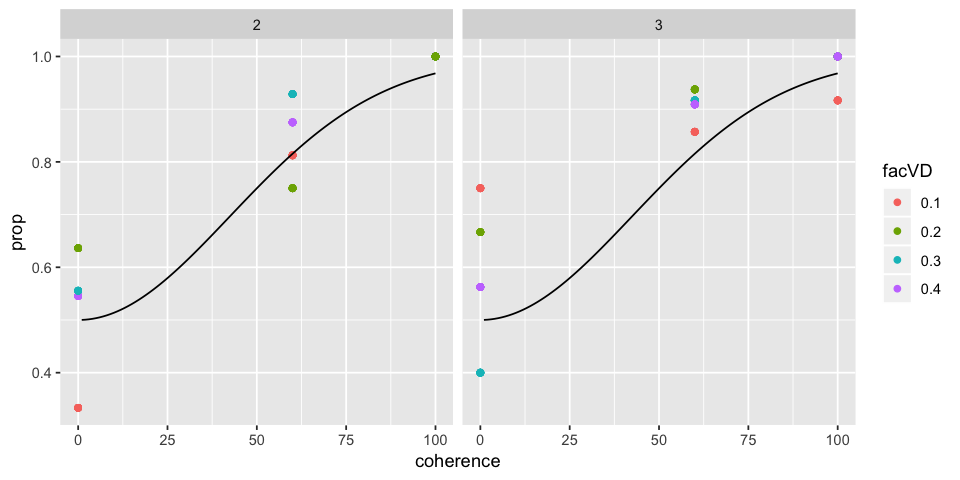

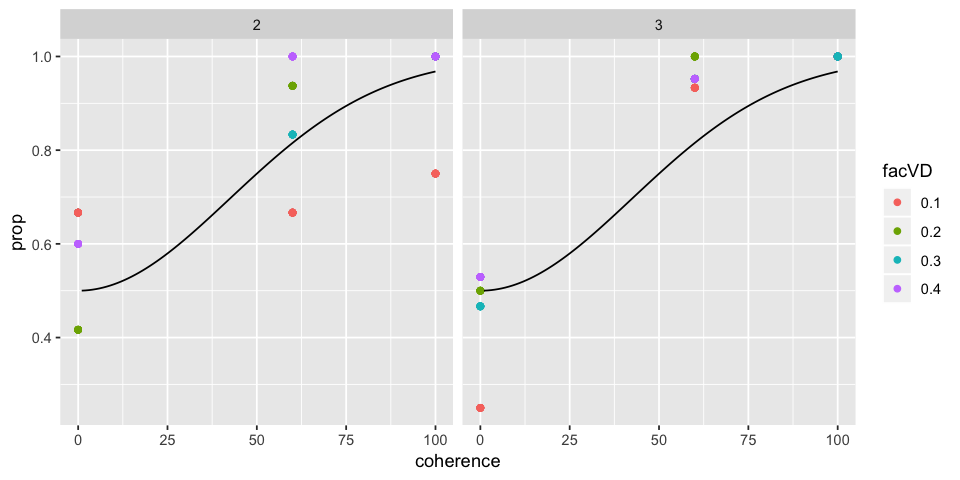

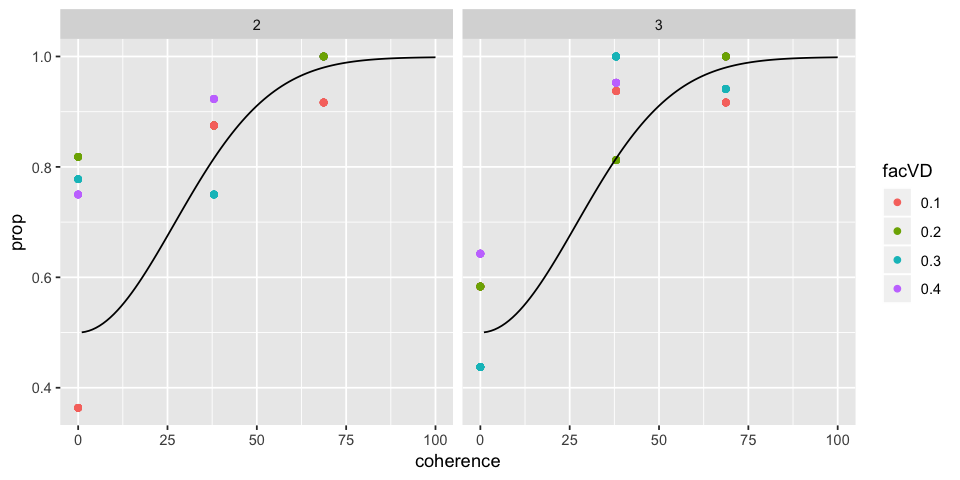

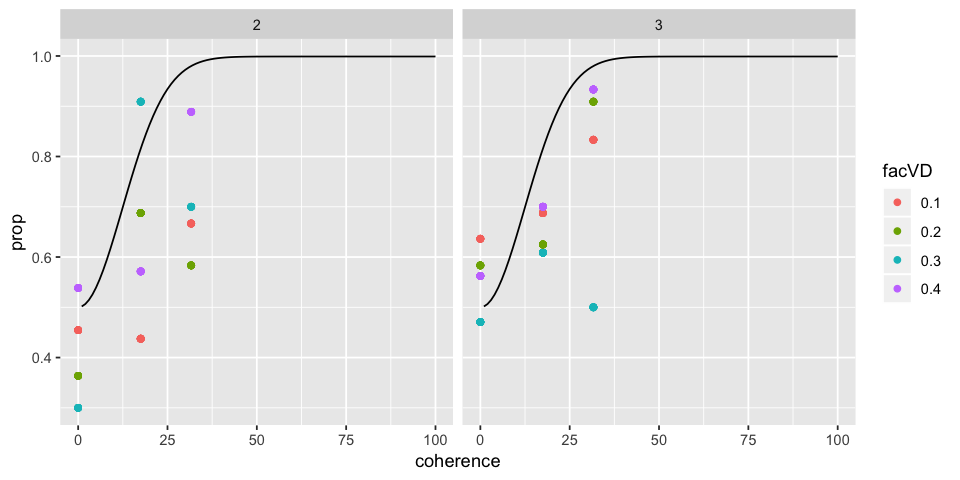

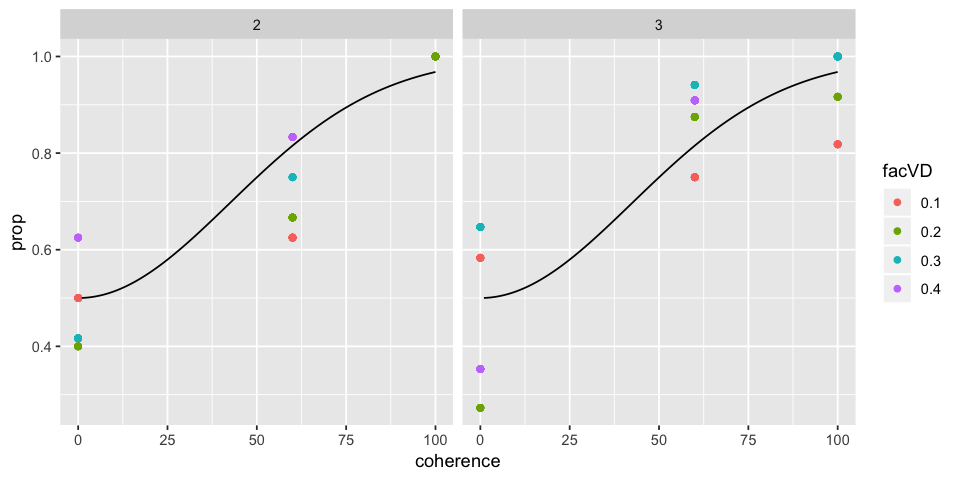

In [14]:
x <- seq(100)

for (subj in names(QuestParams)) {
    psychometric <- psi_corr(weibull, QuestParams[[subj]])
    y <- psychometric(x)
    questCurve <- data.table(x=x, y=y)
    
    # control output figure size
    options(repr.plot.width=8, repr.plot.height=4)

    pp <- ggplot(data[pilotID==subj & taskID > 1 & presenceCP=='no',
                      .(facVD, prop=sum(correct==TRUE)/.N),
                      by=.(coherence, viewingDuration, taskID)], 
                 aes(x=coherence, y=prop)) +
             geom_point(aes(col=facVD)) + 
             facet_grid(.~taskID) + 
             geom_line(aes(x=x, y=y), data=questCurve)
    plot(pp)
}

### Proportion Choose Right

Let's fit simple logistic models, grouping by *subject and viewing duration*. 

In [ ]:
# for an explanation of masked objects, see here:
# https://stackoverflow.com/a/39137111
# library(quickpsy)
print("I skip this section to avoid using the 'quickpsy' package for now")

In [ ]:
# data[,numChoice:=0]
# data[choice=='right',numChoice:=1]

In [ ]:
# fit <- quickpsy(data[taskID==2], signedCohLast, numChoice, grouping=.(pilotID, facVD))

In [ ]:
# names(fit)

In [ ]:
# from http://dlinares.org/basicsquickpsy.html
# ggplot() +
#  facet_wrap(~pilotID) +
#  geom_line(data = fit$curvesbootstrap, aes(x = x, y = y, color = facVD, 
#                    group=paste(sample,facVD)), lwd = .2, alpha = .4) +   
#  geom_line(data = fit$curves, aes(x = x, y = y, group = facVD), 
#            color = 'black') +
#  geom_point(data = fit$averages, aes(x = signedCohLast, y = prob, color = facVD), size = 4)

## Simplest effects of CP on percent correct

**Question:** Does the physical presence of a CP affect state inference?  
**Hypotheses:** At fixed viewing duration the (physical) presence of a CP will decrease accuracy.  
**Method:** Hypothesis testing, i.e. is the difference in percent correct between the `CP` and `nonCP` conditions significantly different from 0?

Let's build a contingency table and perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test#Example).

In [ ]:
subj <- '13'
task <- '2'
vd <- .4
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

In [ ]:
subj <- '14'
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

We conclude that the test is not significant, i.e., we do **not** reject the null hypothesis that percent correct is the same with and without change points.

## Logistic regression

### Single predictor

#### Signed coherence
<a id="cohpred"></a>

We start by fitting our simplest logistic regression model, called **M1**
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{sc}_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x^\text{sc}$ is the signed coherence value.

And for now, let's only study one subject.

In [61]:
subj <- '15'
task <- '2'

In [62]:
# simplify existing dataset in order to consider 1 subject and 1 task:
single <- data[taskID==task & pilotID==subj]
# head(single)

In [63]:
# fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)
M1 <- glm(choice ~ signedCohLast, single, family=binomial())
M1


Call:  glm(formula = choice ~ signedCohLast, family = binomial(), data = single)

Coefficients:
  (Intercept)  signedCohLast  
      0.01033        0.03067  

Degrees of Freedom: 195 Total (i.e. Null);  194 Residual
Null Deviance:	    271.4 
Residual Deviance: 164.4 	AIC: 168.4

In [64]:
coherences <- seq(-100,100,10)
predictions <- my_logistic(coherences, linear_func(coef(summary(M1))))

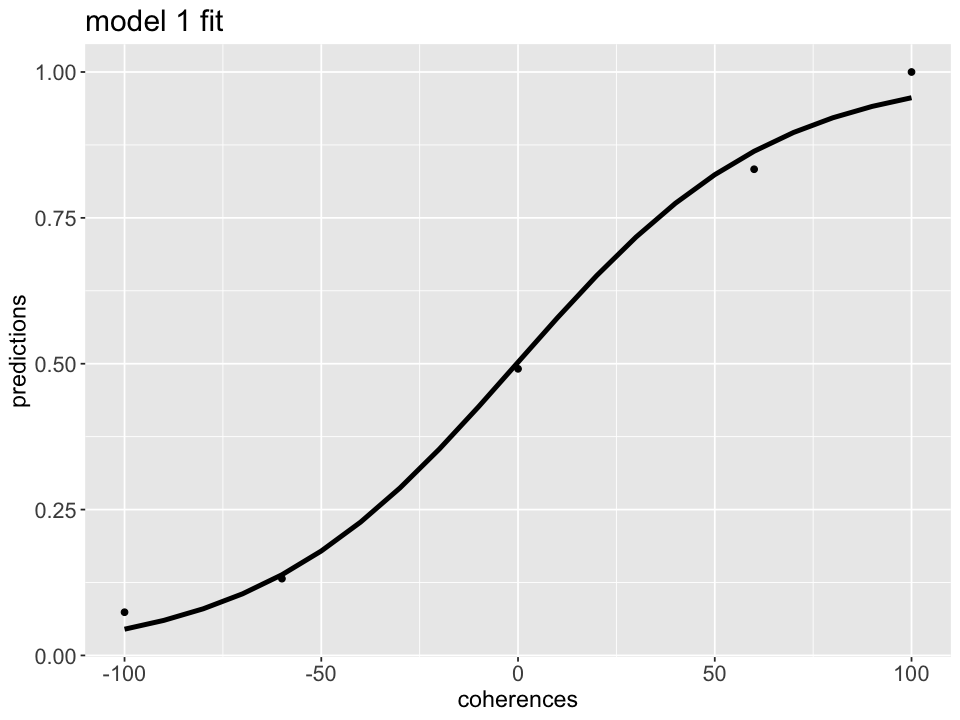

In [65]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data.table(coherences, predictions), aes(x=coherences, y=predictions)) +
    geom_line(size = 1.4) + 
    geom_point(aes(x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,.(propRight=sum(choice=='right')/.N),by=.(signedCohLast)]) +
    labs(title='model 1 fit') + 
    mytheme    

In [66]:
# subj <- '14'
# unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

In [67]:
# fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

### More predictors
#### Single subject

Let's first try to fit what we call **Model 2**, or **M2**.
$$ \text{logit}(p_\text{right}) =\beta_0+
    \sum_{i\in\text{VDs}}\mathbb{1}_{\text{VD}_i}
    \beta^{VD\textsf{x}coh}_iX_{coh}$$

In [68]:
M2 <- glm(choice ~ signedCohLast:facVD, data=single, family=binomial())

In [69]:
M2


Call:  glm(formula = choice ~ signedCohLast:facVD, family = binomial(), 
    data = single)

Coefficients:
           (Intercept)  signedCohLast:facVD0.1  signedCohLast:facVD0.2  
               0.01538                 0.03109                 0.02662  
signedCohLast:facVD0.3  signedCohLast:facVD0.4  
               0.03020                 0.03430  

Degrees of Freedom: 195 Total (i.e. Null);  191 Residual
Null Deviance:	    271.4 
Residual Deviance: 164 	AIC: 174

We will overlay the fitted psychometric curves for each viewing duration:

In [70]:
# we gather all the predictions in a single data.table
factor_levels <- levels(single[,facVD])
num_factors = length(factor_levels)
coherence <- rep(coherences, times=num_factors)  # coherences defined in some cell above
VD <- c()
predictions <- c()

In [71]:
for (vd in factor_levels) {
    VD <- c(VD, rep(c(vd), times = length(coherences)))
    coef_names <- c("(Intercept)", paste("signedCohLast:facVD",vd,sep=''))
    fitted_betas <- coef(summary(M2))[coef_names, "Estimate"]
    eta <- linear_func(fitted_betas)
    predictions <- c(predictions, my_logistic(coherences, eta))
}

In [72]:
prediction_data <- data.table(coherence, VD, predictions)
prediction_data[,VD:=as.factor(VD)]

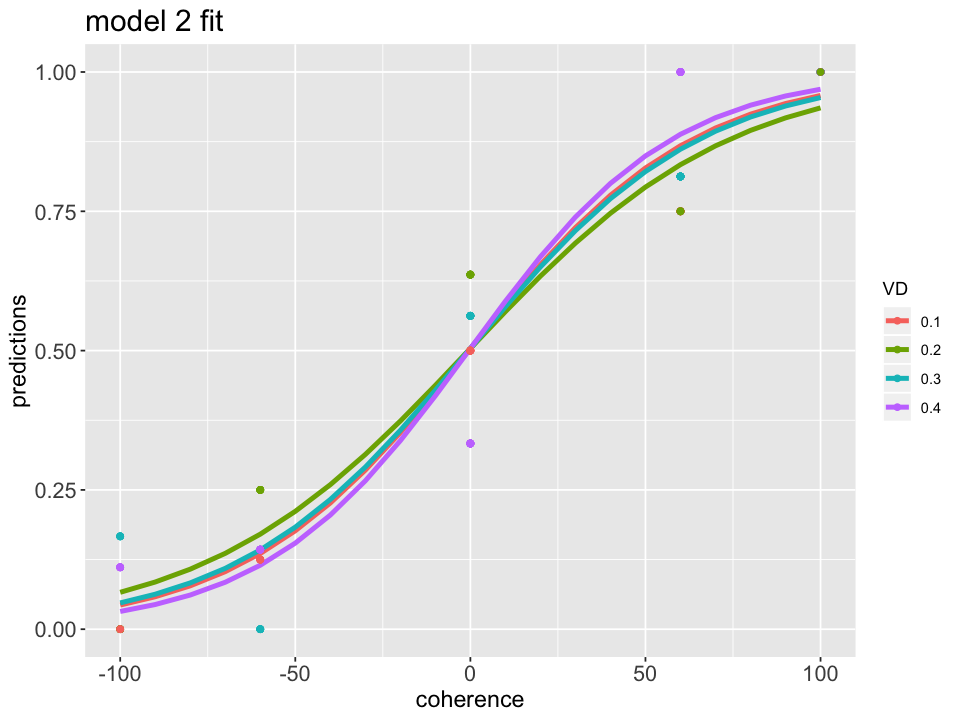

In [73]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(prediction_data, aes(x=coherence, y=predictions)) +
    geom_line(aes(col=VD), size = 1.4) + 
    geom_point(aes(col=facVD, x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,propRight:=sum(choice=='right')/.N,by=.(signedCohLast, facVD)]) +
    labs(title='model 2 fit') +
    mytheme    

Can we already select between M1 and M2?

We now tackle **Model 3**, or **M3**.
$$ \text{logit}(p_\text{right}) =\beta_0+
    \sum_{j\in\text{CPs}}\mathbb{1}_{\text{CP}_j} 
    \beta^{CP\textsf{x}coh}_jX_{coh}$$

In [74]:
M3 <- glm(choice ~ signedCohLast:presenceCP, data=single, family=binomial())
M3


Call:  glm(formula = choice ~ signedCohLast:presenceCP, family = binomial(), 
    data = single)

Coefficients:
                (Intercept)   signedCohLast:presenceCPno  
                    0.01699                      0.03364  
signedCohLast:presenceCPyes  
                    0.02235  

Degrees of Freedom: 195 Total (i.e. Null);  193 Residual
Null Deviance:	    271.4 
Residual Deviance: 162.9 	AIC: 168.9

In [75]:
# we gather all the predictions in a single data.table, just as for model 2
factor_levels <- levels(single[,presenceCP])
num_factors = length(factor_levels)
coherence <- rep(coherences, times=num_factors)  # coherences defined in some cell above
CP <- c()
predictions <- c()
for (cp in factor_levels) {
    CP <- c(CP, rep(c(cp), times = length(coherences)))
    coef_names <- c("(Intercept)", paste("signedCohLast:presenceCP",cp, sep=''))
    fitted_betas <- coef(summary(M3))[coef_names, "Estimate"]
    eta <- linear_func(fitted_betas)
    predictions <- c(predictions, my_logistic(coherences, eta))
}
prediction_data <- data.table(coherence, CP, predictions)
prediction_data[,CP:=as.factor(CP)]

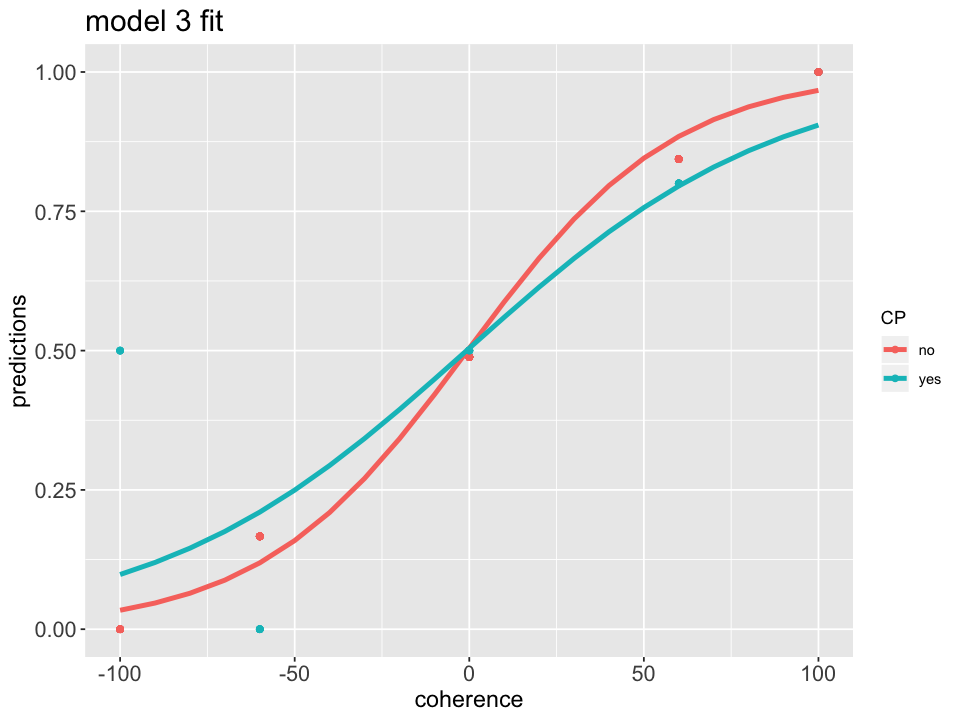

In [76]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(prediction_data, aes(x=coherence, y=predictions)) +
    geom_line(aes(col=CP), size = 1.4) + 
    geom_point(aes(col=presenceCP, x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,propRight:=sum(choice=='right')/.N,by=.(signedCohLast, presenceCP)]) +
    labs(title='model 3 fit') +
    mytheme   

Finally, let's fit **Model 4**, i.e. **M4**:
$$ \text{logit}(p_\text{right}) =
\beta_0 +
    \sum_{(i,j)\in\text{VDs}\times\text{CPs}}
    \left(
    \beta^{VD\textsf{x}coh}_i\mathbb{1}_{\text{VD}_i}+
    \beta^{CP\textsf{x}coh}_j\mathbb{1}_{\text{CP}_j}
    \right)
    X_{coh}$$

In [77]:
M4 <- glm(choice ~ facVD + signedCohLast:facVD + presenceCP + signedCohLast:presenceCP - 1, data=single, family=binomial())
M4


Call:  glm(formula = choice ~ facVD + signedCohLast:facVD + presenceCP + 
    signedCohLast:presenceCP - 1, family = binomial(), data = single)

Coefficients:
                   facVD0.1                     facVD0.2  
                   -0.18793                      0.26483  
                   facVD0.3                     facVD0.4  
                   -0.03507                     -0.15842  
              presenceCPyes       facVD0.1:signedCohLast  
                    0.18716                      0.03128  
     facVD0.2:signedCohLast       facVD0.3:signedCohLast  
                    0.02696                      0.04002  
     facVD0.4:signedCohLast  signedCohLast:presenceCPyes  
                    0.04238                     -0.01898  

Degrees of Freedom: 196 Total (i.e. Null);  186 Residual
Null Deviance:	    271.7 
Residual Deviance: 160.6 	AIC: 180.6

In model 4 above, I am not sure why the fit doesn't provide me for a pair of coefficients for the 'no' CP case...

In [78]:
anova(M1, M2, M3, M4)

Resid. Df,Resid. Dev,Df,Deviance
194,164.3985,NA,NA
191,163.9590,3,0.4394762
193,162.8839,-2,1.0751461
186,160.5570,7,2.3268476
